True


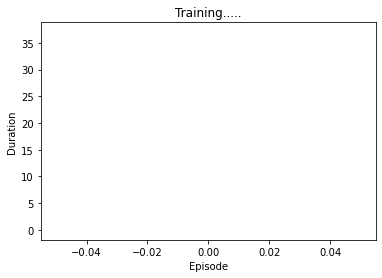

Episode 1 
 100 episode moving avg:  0.0


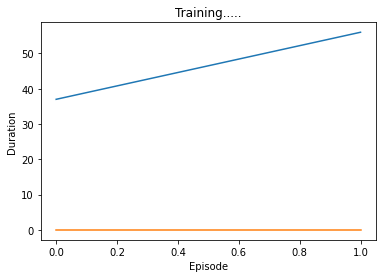

Episode 2 
 100 episode moving avg:  0.0


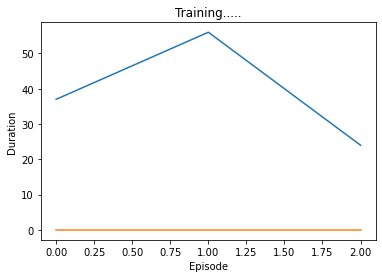

Episode 3 
 100 episode moving avg:  0.0


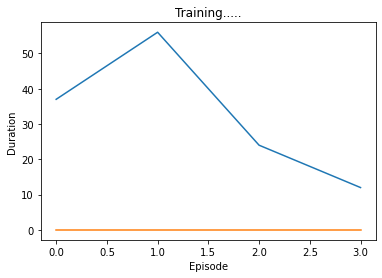

Episode 4 
 100 episode moving avg:  0.0


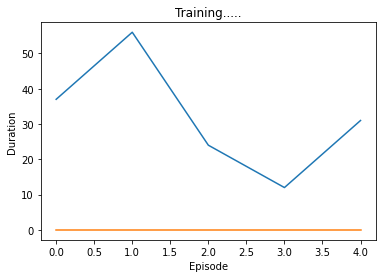

Episode 5 
 100 episode moving avg:  0.0


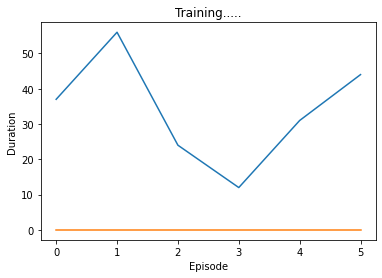

Episode 6 
 100 episode moving avg:  0.0


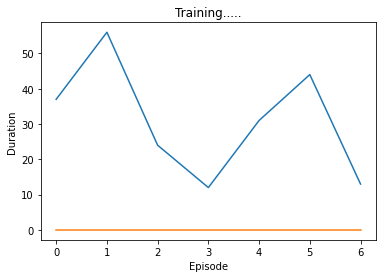

Episode 7 
 100 episode moving avg:  0.0


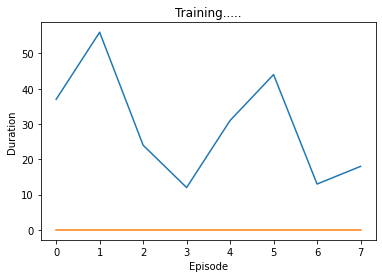

Episode 8 
 100 episode moving avg:  0.0


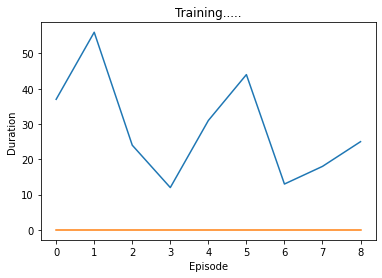

Episode 9 
 100 episode moving avg:  0.0


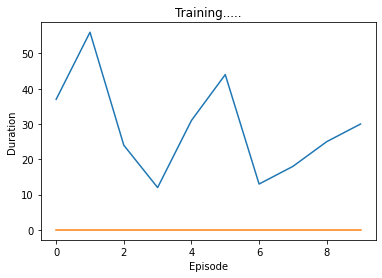

Episode 10 
 100 episode moving avg:  0.0


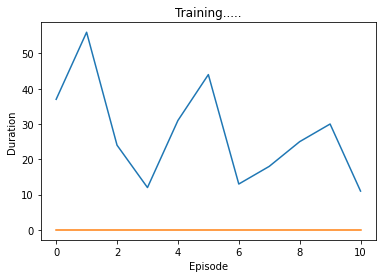

Episode 11 
 100 episode moving avg:  0.0


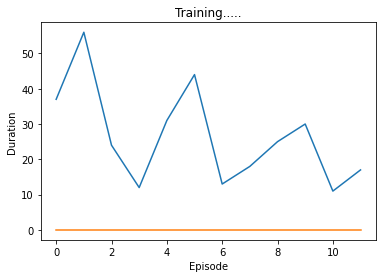

Episode 12 
 100 episode moving avg:  0.0


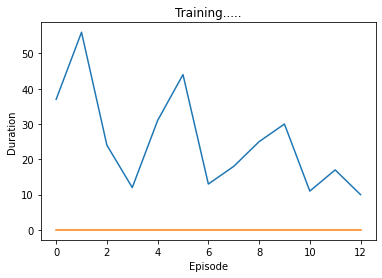

Episode 13 
 100 episode moving avg:  0.0


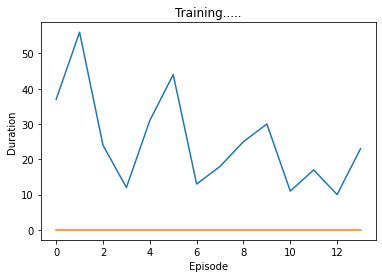

Episode 14 
 100 episode moving avg:  0.0


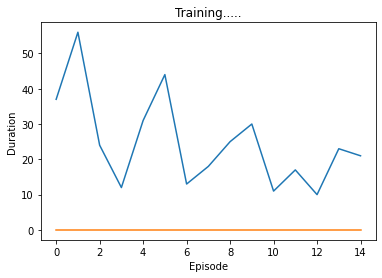

Episode 15 
 100 episode moving avg:  0.0


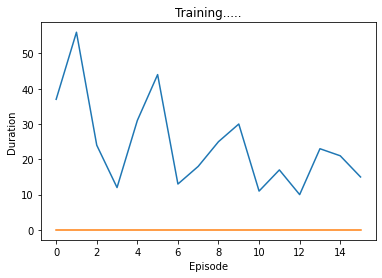

Episode 16 
 100 episode moving avg:  0.0


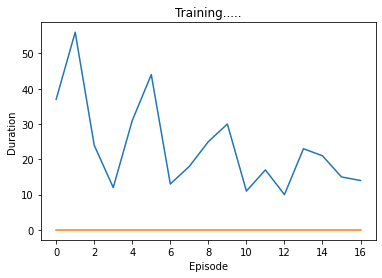

Episode 17 
 100 episode moving avg:  0.0


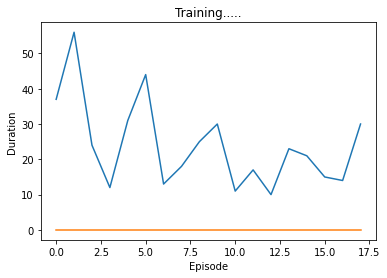

Episode 18 
 100 episode moving avg:  0.0


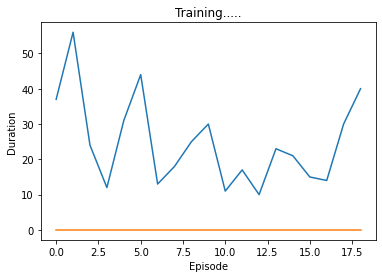

Episode 19 
 100 episode moving avg:  0.0


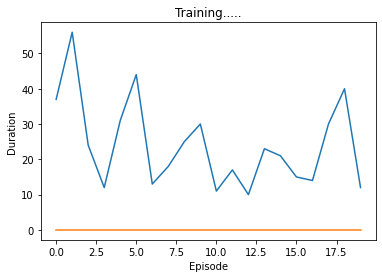

Episode 20 
 100 episode moving avg:  0.0


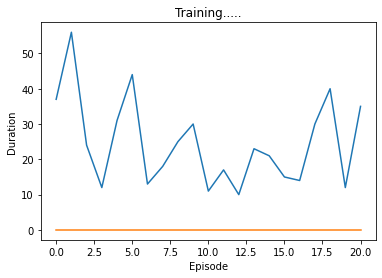

Episode 21 
 100 episode moving avg:  0.0


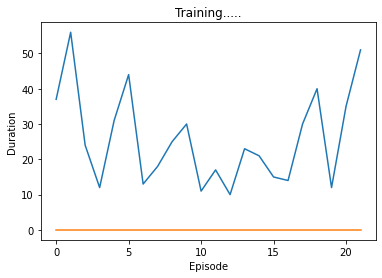

Episode 22 
 100 episode moving avg:  0.0


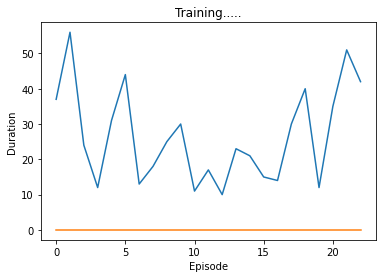

Episode 23 
 100 episode moving avg:  0.0


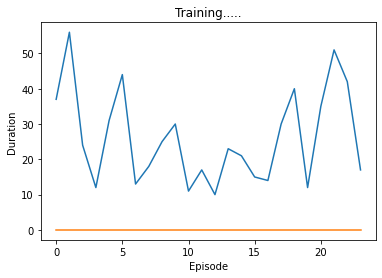

Episode 24 
 100 episode moving avg:  0.0


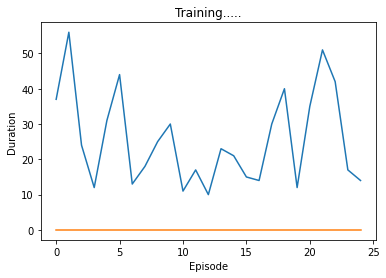

Episode 25 
 100 episode moving avg:  0.0


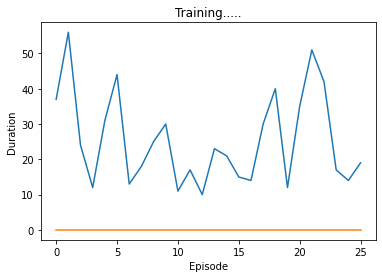

Episode 26 
 100 episode moving avg:  0.0


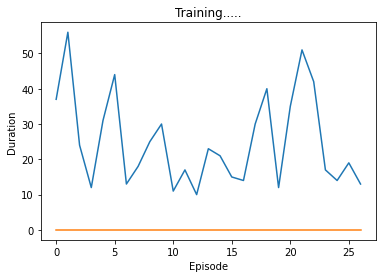

Episode 27 
 100 episode moving avg:  0.0


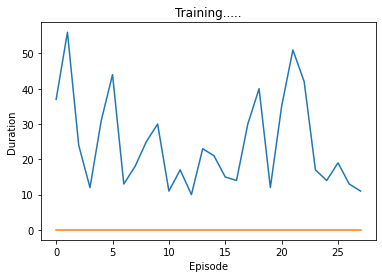

Episode 28 
 100 episode moving avg:  0.0


KeyboardInterrupt: 

In [2]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
%matplotlib inline

# In[2]:

'''
is_ipython = 'inline' in matplotlib.get_backend()
print(is_ipython)
if is_ipython: from IPython import display
'''

# In[3]:


class DQN(nn.Module):
    def __init__(self,img_height, img_width):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features = img_height*img_width*3, out_features = 24)
        self.fc2 = nn.Linear(in_features = 24, out_features = 32)
        self.out = nn.Linear(in_features = 32, out_features = 2)
    def forward(self, t):
        t = t.flatten(start_dim = 1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t


# In[4]:


Experience = namedtuple('Experience',('state','action','next_state','reward'))


# In[5]:


e = Experience(2,3,1,4)


# In[6]:


e


# In[7]:


e.state


# In[8]:


class ReplayMemory():
    def __init__(self,capacity):
        self.capacity = capacity
        self.memory = []
        self.push_count = 0
    def push(self,experience):
        if len(self.memory) < self.capacity:
            self.memory.append(experience)
        else:
            self.memory[self.push_count%self.capacity]=experience
        self.push_count +=1
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def can_provide_sample(self, batch_size):
        return len(self.memory)>=batch_size


# In[9]:


class EpsilonGreedyStrategy():
    def __init__(self,start,end,decay):
        self.start = start
        self.end = end
        self.decay = decay
    def get_exploration_rate(self, current_step):
        return self.end + (self.start-self.end)*math.exp(-1*current_step*self.decay)


# In[ ]:





# In[10]:


class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.device = device
        self.strategy = strategy
        self.num_actions = num_actions
    def select_action(self, state, policy_net):
        rate = strategy.get_exploration_rate(self.current_step)
        self.current_step +=1
        
        if rate > random.random():
            # explore
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(device)
        else:
            # exploit
            with torch.no_grad():
                return policy_net(state).argmax(dim = 1).to(device)


# In[ ]:





# In[11]:


class CartPoleEnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False
        
    def reset(self):
        self.env.reset()
        self.current_screen = None
    
    def close(self):
        self.env.close()
    
    def render(self, mode = 'human'):
        return self.env.render(mode)
    
    def num_actions_available(self):
        return self.env.action_space.n
    
    def take_action(self,action):
        useless, reward, self.done, uselessPart2 = self.env.step(action.item())
        return torch.tensor([reward], device = self.device)
    
    def just_starting(self):
        return self.current_screen is None
    
    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2-s1
        
    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]
    
    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2, 0, 1)) # PyTorch expects CHW
        screen = self.crop_screen(screen)
        return self.transform_screen_data(screen)
    
    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:,top:bottom,:]
        return screen
    
    def transform_screen_data(self, screen):       
        # Convert to float, rescale, convert to tensor
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
    
        # Use torchvision package to compose image transforms
        resize = T.Compose([
            T.ToPILImage()
            ,T.Resize((40,90))
            ,T.ToTensor()
        ])
    
        return resize(screen).unsqueeze(0).to(self.device)


# In[12]:


print(torch.cuda.is_available())


class QValues():
    device = torch.device("cuda")
    
    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim = 1, index = actions.unsqueeze(-1))
    
    @staticmethod
    def get_next(target_net, next_states):
        # we flatten the values of the pixels in each of the next_states and then
        # compare the max of them to 0 as the ending state will have a blank black 
        # screen and then store those locations(indices of states) as True
        final_state_locations = next_states.flatten(start_dim = 1).max(dim = 1)[0].eq(0).type(torch.bool)
        # just flipping the above tensor's bool values
        non_final_state_locations = (final_state_locations == False)
        # tensors allow slicing with a tensor of bool values, not just indices
        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        # initialising a tensor of length of states made of zeros
        values = torch.zeros(batch_size).to(QValues.device)
        # sets values of q* function only in the states without a terminal 
        # ending and then returns the max out of them
        values[non_final_state_locations] = target_net(non_final_states).max(dim = 1)[0].detach()
        return values


# In[18]:


def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.title('Training.....')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = get_moving_average(moving_avg_period, values)
    plt.plot(moving_avg)
    plt.pause(0.001)
    print("Episode", len(values),"\n",moving_avg_period, "episode moving avg: ",moving_avg[-1])
    #if is_ipython: display.clear_output(wait = True)

def get_moving_average(period, values):
    values = torch.tensor(values, dtype = torch.float)
    if (len(values)>= period):
        moving_avg = values.unfold(dimension = 0, size = period, step = 1).mean(dim = 1).flatten(start_dim = 0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()


# In[19]:


def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))
    
    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)
    
    return (t1,t2,t3,t4)


# In[20]:


batch_size = 256
gamma = 0.999
eps_start = 1
eps_end = 0.01
eps_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000


# In[21]:


device = torch.device("cuda")
em = CartPoleEnvManager(device)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params = policy_net.parameters(), lr = lr)
episode_durations = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    
    for timestep in count():
        action = agent.select_action(state,policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()
        memory.push(Experience(state, action, next_state, reward))
        state = next_state
        
        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)
            
            current_q_values = QValues.get_current(policy_net,states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards
            
            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if em.done:
            episode_durations.append(timestep)
            plot(episode_durations,100)
            break
        
    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())
em.close()


# In[ ]:





# In[ ]:





# In[ ]:




